# Classification Task

In this notebook we aim to train, validate and test a neural net to classify between:
* one galaxy behind one foreground galaxy
* two galaxies at the same redshift and with small angular separation (1 to 4 arcseconds)

These datasets were created in notebook `1_create_simulations`.

This notebook also incorporates the critical diagnostics described in [Training a Machine Learning Model](https://docs.google.com/document/d/1U17RNPqDA5uP9-M5V3ENweKig5eRZWHTpja-hh1z1MI/edit).

#### Index<a name="index"></a>
1. [Import Packages](#imports)
2. [Load data](#load)
3. [Process data](#process)
    1. [Ingest the data](#ingest)
    2. [Get dataloader](#dataloader)
4. [Train network](#train)
    1. [Save performance](#savePerformance)
    2. [Predict class](#predict)
    3. [Confusion matrix](#cm)


## 1. Import Packages<a name="imports"></a>

In [1]:
import sys
import time
import glob

In [2]:
import numpy as np
import pandas as pd
import torch
import process
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.append('../Network')
import data_utils
import networks
import training
import save
import predict

In [4]:
from sklearn.metrics import confusion_matrix

### Aestetic settings

In [5]:
%matplotlib inline
%config Completer.use_jedi = False  # enable autocomplete

size_default = 1.5
size_larger = 1.9
sns.set(font_scale=size_default, style="ticks")

## Notebook Options

In [23]:
is_processed = 1  # Set to 0 if the data has not yet been processed
is_trained = 0  # Set to 0 if the network has not yet been trained

# Select the network type
#net_type = 'CNN'
net_type = 'RNN'
# net_type = 'ZIPPER'

## 2. Load data<a name="load"></a>

In [7]:
dataset_name = 'high_cad_1_2_data'
directory = dataset_name

[Go back to top.](#index)

### 2.1. Process data<a name="process"></a>

Following [DeepZipper paper](https://arxiv.org/pdf/2112.01541.pdf), we condense the image information to single-image input by averaging all images in the time series on a pixel-by-pixel basis within each band.

This also augments the training set by rotating and morroring the images.

In [8]:
if not is_processed:
    configurations = [x.split("/")[1].split("_images.")[0] for x in glob.glob(f"{directory}/*_images.npy")]
    
    ini_time = time.time()
    for configuration in sorted(configurations):
        process.run(directory, configuration)
    print(time.time() - ini_time)

### 2.2. Original data<a name="loadOri"></a>

Configuration 1:

In [9]:
images_config1_ori = np.load(dataset_name+'/CONFIGURATION_1_images.npy')
metadata_config1_ori = pd.read_csv(dataset_name+'/CONFIGURATION_1_metadata.csv', sep=',')

In [10]:
print(np.shape(images_config1_ori))
print(np.shape(metadata_config1_ori))
print('# events: ', len(np.unique(metadata_config1_ori['OBJID-g'])))

(4665, 4, 45, 45)
(4665, 324)
# events:  311


Configuration 2:

In [11]:
images_config2_ori = np.load(dataset_name+'/CONFIGURATION_2_images.npy')
metadata_config2_ori = pd.read_csv(dataset_name+'/CONFIGURATION_2_metadata.csv', sep=',')

In [12]:
print(np.shape(images_config2_ori))
print(np.shape(metadata_config2_ori))
print('# events: ', len(np.unique(metadata_config2_ori['OBJID-g'])))

(2055, 4, 45, 45)
(2055, 416)
# events:  137


### 2.3. Processed data<a name="loadAug"></a>

Configuration 1:

In [13]:
images_config1 = np.load(dataset_name+'/CONFIGURATION_1_proc_ims_15.npy')
metadata_config1 = np.load(dataset_name+'/CONFIGURATION_1_proc_mds_15.npy', 
                           allow_pickle=True).item()

In [14]:
print(np.shape(images_config1))
print(np.shape(metadata_config1[0]))
print('# events: ', len(metadata_config1.keys()))

(2488, 4, 45, 45)
(15, 324)
# events:  2488


Configuration 2:

In [15]:
images_config2 = np.load(dataset_name+'/CONFIGURATION_2_proc_ims_15.npy')
metadata_config2 = np.load(dataset_name+'/CONFIGURATION_2_proc_mds_15.npy', 
                           allow_pickle=True).item()

In [16]:
print(np.shape(images_config2))
print(np.shape(metadata_config2[0]))
print('# events: ', len(metadata_config2.keys()))

(1096, 4, 45, 45)
(15, 416)
# events:  1096


In [17]:
# Show rotation of the images
# from deeplenstronomy.visualize import view_image, view_image_rgb
# view_image_rgb(images_config2[1], Q=10, stretch=1)
# view_image_rgb(images_config2[138], Q=10, stretch=1)
# view_image_rgb(images_config2[275], Q=10, stretch=1)

## 3. Prepare data for network<a name="prepare"></a>

### 3.1. Train/Test set split<a name="split"></a>

In [18]:
train_dataset, test_dataset = data_utils.make_train_test_datasets(
    directory=dataset_name, class_names=['CONFIGURATION_1_proc', 'CONFIGURATION_2_proc'], 
    suffix='15', label_map={})

(2488, 15, 4)
0
(1096, 15, 4)
1


In [19]:
np.shape(train_dataset.images) # I thought we added all the images? Why still many filters??

(3225, 4, 45, 45)

### 3.2. Get dataloader<a name="dataloader"></a>

In [20]:
train_dataloader = data_utils.make_dataloader(train_dataset)

### 3.3. Data Histogram<a name="dataHist"></a>

In [21]:
dict_label_to_real = {0: 'gal-gal', 1: '2 gals'}

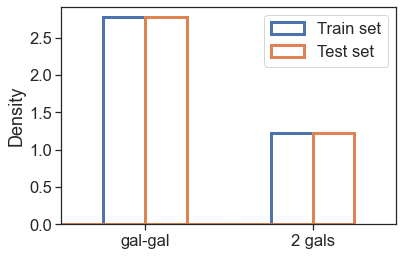

In [22]:
bins = np.arange(-.5, 1.5, 0.25)
sns.histplot(data=train_dataset.labels-.25, kde=False, stat='density', 
             bins=bins,
             color='C0', label='Train set', linewidth=3, fill=False)
sns.histplot(data=test_dataset.labels, kde=False, stat='density', 
             bins=bins, 
             color='C1', label='Test set', linewidth=3, fill=False)
plt.xticks(ticks=[0, 1], labels=[dict_label_to_real[0], dict_label_to_real[1]])
plt.xlim(-.5, 1.5)
plt.legend()

[Go back to top.](#index)

## 4. Train network<a name="train"></a>

In [24]:
network_types = {'ZIPPER': networks.ZipperNN(4, 4, 4),
                 'CNN': networks.CNN_single(4, 2),
                 'RNN': networks.RNN_single(4, 3)}

network = network_types[net_type]

In [25]:
if not is_trained:
    ini_time = time.time()
    if net_type == 'ZIPPER':
        network = training.train_zipper(network, train_dataloader,
                                        train_dataset, test_dataset,
                                        monitor=True,
                                        outfile_prefix=f"{dataset_name}/{dataset_name}_{net_type}")
    else:
        if net_type == 'CNN':
            datatype = 'image'
        elif net_type == 'RNN':
            datatype = 'lightcurve'
        else:
            raise ValueError('`net_type` {net_type} not recognised')
        network = training.train_single(network, train_dataloader, 
                                    train_dataset, test_dataset,
                                    datatype, monitor=True,
                                    outfile_prefix=f"{dataset_name}/{dataset_name}_{net_type}")
    print(time.time() - ini_time)

Epoch: 1 Batch: 1  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 1.049
Epoch: 1 Batch: 501  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.546
Epoch: 2 Batch: 1  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.507
Epoch: 2 Batch: 501  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.523
Epoch: 3 Batch: 1  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.478
Epoch: 3 Batch: 501  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 1.109
Epoch: 4 Batch: 1  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.531
Epoch: 4 Batch: 501  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.692
Epoch: 5 Batch: 1  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.527
Epoch: 5 Batch: 501  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- Loss: 0.531
Epoch: 6 Batch: 1  | Training Accuracy: 0.710 -- Validation Accuracy: 0.694 -- L

[Go back to top.](#index)

### 4.1. Save performance<a name="savePerformance"></a>

In [26]:
if not is_trained:
    print("Saving results")
    # Save the performance
    save.save_performance(dataset_name, dataset_name, net_type, network, test_dataset)
    save.save_performance(dataset_name, dataset_name, net_type, network, train_dataset, train=True)

Saving results


[Go back to top.](#index)

### 4.2. Load network<a name="loadNetwork"></a>

If the network was previously ran, simply load it.

In [27]:
monitor_table = pd.read_csv(directory+f'/{directory}_{net_type}_monitoring.csv', sep=',')

In [28]:
if is_trained:
    network = network_types[net_type]
    network.load_state_dict(torch.load(directory+f'/{directory}_{net_type}_network.pt'))

In [29]:
network

RNN_single(
  (rnn): LSTM(4, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=25, bias=True)
  (out2): Linear(in_features=25, out_features=3, bias=True)
)

In [30]:
network.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[ 0.2621,  0.2426, -0.1595, -0.0334],
                      [-0.0606,  0.0166,  0.0740,  0.1264],
                      [-0.0512,  0.1925,  0.1086,  0.0138],
                      ...,
                      [-0.0060, -0.0606, -0.1519, -0.2607],
                      [-0.0282, -0.0708, -0.1611, -0.2395],
                      [ 0.0081, -0.3645, -0.3284, -0.2073]])),
             ('rnn.weight_hh_l0',
              tensor([[ 0.1577, -0.2527,  0.1046,  ..., -0.0633,  0.0725, -0.0149],
                      [-0.1198,  0.0741, -0.0776,  ...,  0.0472,  0.0067,  0.0518],
                      [-0.2271,  0.0322, -0.1861,  ...,  0.1719, -0.0053, -0.1695],
                      ...,
                      [-0.0558,  0.0599, -0.1378,  ...,  0.0351, -0.0626, -0.0960],
                      [ 0.0698, -0.0495,  0.0003,  ...,  0.0311, -0.0157, -0.0266],
                      [ 0.0686,  0.1141, -0.1873,  ..., -0.0141, -0.0772, -0.0088]])),
        

[Go back to top.](#index)

### 4.3. Predict class<a name="predict"></a>

In [31]:
predictions, labels = predict.predict(network, test_dataset) 
accuracy = np.sum(predictions == labels) / len(labels)

Accuracy: 0.6935933147632312


[Go back to top.](#index)

## 5. Results<a name="results"></a>

### 5.1. Confusion matrix<a name="cm"></a>

In [32]:
def plot_confusion_matrix(y_true, y_pred, title=None, normalise=None,
                          dict_label_to_real=None, figsize=None, **kwargs):
    """Plot a confusion matrix.

    Uses the true and predicted class labels to compute a confusion matrix.
    This can be non-normalised, normalised by true class/row (the diagonals
    show the accuracy of each class), and by predicted class/column (the
    diagonals show the precision).

    Parameters
    ----------
    y_true : 1D array-like
        Ground truth (correct) labels of shape (n_samples,).
    y_true : 1D array-like
        Predicted class labels of shape (n_samples,).
    title : {None, str}, optional
        Title of the plot.
    normalise : {None, str}, optional
       If `None`, use the absolute numbers in each matrix entry. If 'accuracy',
       normalise per true class. If 'precision', normalise per predicted class.
    dict_label_to_real : dict, optional
        Dictionary containing the class labels as key and its real name as
        values. E.g. for PLAsTiCC
        `dict_label_to_real = {42: 'SNII', 62: 'SNIbc', 90: 'SNIa'}`.
        If `None`, the default class labels are used.
    figsize : {None, tuple}
        If `None`, use the default `figsize` of the plot. Otherwise, create a
        figure with the given size.

    Returns
    -------
    cm : np.array
       The confusion matrix, as computed by `sklearn.metrics.confusion_matrix`.
    """
    # Make and normalise the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalise == 'accuracy':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        kwargs = {'vmin': 0, 'vmax': 1}
        print("Confusion matrix normalised by true class.")
    elif normalise == 'precision':
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        kwargs = {'vmin': 0, 'vmax': 1}
        print("Confusion matrix normalised by predicted class.")
    else:
        print('Confusion matrix without normalisation')

    # Classes in the dataset
    target_names = np.unique(y_true)
    target_names_ori = np.copy(target_names)  # the labels might be strings
    if dict_label_to_real is not None:
        target_names = np.vectorize(dict_label_to_real.get)(target_names)
        if target_names[0] is None:  # fix the names being strings
            target_names = list(map(int, target_names_ori))

    # Plot the confusion matrix
    if figsize is not None:
        _, ax = plt.subplots(figsize=figsize)  # good values: (9, 7)
    else:
        _, ax = plt.subplots()
    sns.heatmap(cm, xticklabels=target_names,
                yticklabels=target_names, cmap='Blues',
                annot=True, fmt='.2f', lw=0.5,
                cbar_kws={'label': 'Fraction of events',
                          'shrink': .82}, **kwargs)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_aspect('equal')
    if title is not None:
        plt.title(title)

    return cm

Confusion matrix normalised by true class.


array([[1., 0.],
       [1., 0.]])

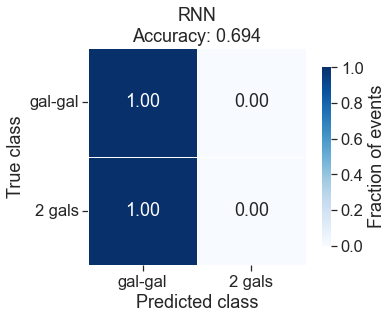

In [33]:
plot_confusion_matrix(y_true=labels, y_pred=predictions, 
                      normalise='accuracy', 
                      title=net_type+f'\nAccuracy: {accuracy:.3f}', 
                      dict_label_to_real={0:'gal-gal', 1:'2 gals'})

[Go back to top.](#index)

### 5.2. Learning curve<a name="learningCurve"></a>

Text(0.5, 1.0, 'Learning curve')

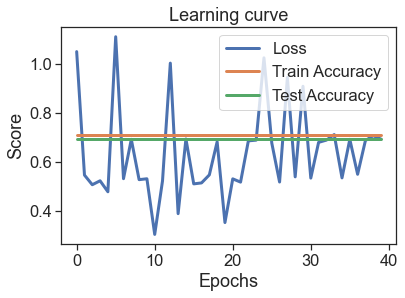

In [34]:
plt.plot(monitor_table['Loss'], linewidth=3, label='Loss')
plt.plot(monitor_table['Train Acc'], linewidth=3, label='Train Accuracy')
plt.plot(monitor_table['Test Acc'], linewidth=3, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Learning curve')

[Go back to top.](#index)